In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [16]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_momentum_type' in cv_results.columns:
        
        filtered_cv_results['momentum'] = cv_results['param_momentum_type']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'n_iter', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 'mean_train_n_iter', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['train_n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)
    filtered_cv_results['val_n_sv'] = cv_results['mean_test_n_sv'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [17]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [18]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


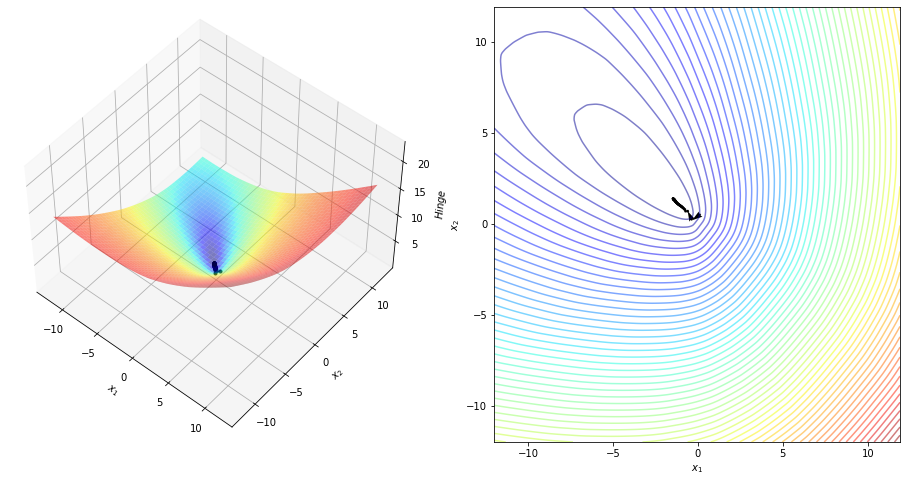

In [19]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5, 
                              max_iter=1000, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [20]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svc_hinge_cv_results.set_index(['solver', 'C'], inplace=True)
custom_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver  C                                                                 
adagrad 1    0.035537      52        0.962537      0.960124          20   
        10   0.055054      99        0.960031      0.960124          16   
        100  0.054262     149        0.960031      0.960124          14   

             val_n_sv  
solver  C              
adagrad 1          11  
        10          9  
        100         8

In [21]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [22]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver    C                                                                 
liblinear 1    0.001025     222        0.995006      0.995025           9   
          10   0.000903     292        0.995006      0.989974           4   
          100  0.001521     967        0.995006      0.989974           3   

               val_n_sv  
solver    C              
liblinear 1           5  
          10          1  
          100         1

In [23]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='h!')
primal_svc_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver    C                                                                 
adagrad   1    0.035537      52        0.962537      0.960124          20   
          10   0.055054      99        0.960031      0.960124          16   
          100  0.054262     149        0.960031      0.960124          14   
liblinear 1    0.001025     222        0.995006      0.995025           9   
          10   0.000903     292        0.995006      0.989974           4   
          100  0.001521     967        0.995006      0.989974           3   

               val_n_sv  
solver    C              
adagrad   1          11  
          10          9  
          100         8  
liblinear 1           5  
          10          1  
          100         1

### Dual formulations

In [24]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [25]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT

class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [59]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1, 
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


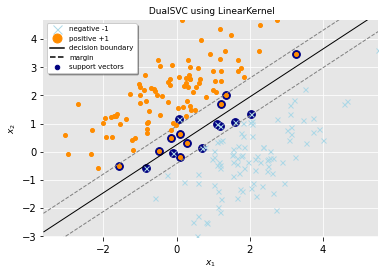

In [27]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [28]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                
cvxopt 1    0.015370      -        0.982494      0.974974          12   
       10   0.023264      -        0.984981      0.969998           8   
       100  0.017700      -        0.982475      0.964948          19   
smo    1    0.036190     27        0.982494      0.974974          12   
       10   0.108871    137        0.984981      0.969998           8   
       100  0.305515    854        0.984981      0.969998           7   

            val_n_sv  
solver C              
cvxopt 1          12  
       10          8  
       100        19  
smo    1          12  
       10          8  
       100         7

In [29]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LibSVM]

In [30]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                 
libsvm 1    0.003119      81        0.989994      0.989974          11   
       10   0.003957     286        0.989994      0.989974           6   
       100  0.002863    1899        0.992481      0.989974           5   

            val_n_sv  
solver C              
libsvm 1          11  
       10          6  
       100         5

In [31]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='h!')
linear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver C                                                                
cvxopt 1    0.015370      -        0.982494      0.974974          12   
       10   0.023264      -        0.984981      0.969998           8   
       100  0.017700      -        0.982475      0.964948          19   
smo    1    0.036190     27        0.982494      0.974974          12   
       10   0.108871    137        0.984981      0.969998           8   
       100  0.305515    854        0.984981      0.969998           7   
libsvm 1    0.003119     81        0.989994      0.989974          11   
       10   0.003957    286        0.989994      0.989974           6   
       100  0.002863   1899        0.992481      0.989974           5   

            val_n_sv  
solver C              
cvxopt 1          12  
       10          8  
       100        19  
smo    1          12  
       10          8  
       100         7  
libsvm 1          11  
       10          6  
       100         5

##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


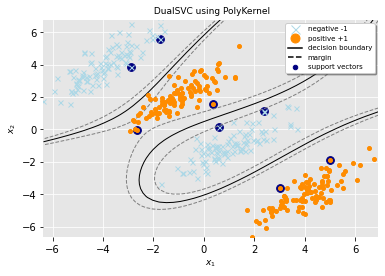

In [32]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [33]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                
cvxopt poly   1    0.083115      -        0.841242      0.671062          31   
              10   0.070198      -        0.961172      0.870609           9   
              100  0.070366      -        0.986248      0.972562           8   
smo    poly   1    0.384261    140        0.847489      0.673568          29   
              10   0.493594    266        0.958675      0.868103           9   
              100  0.417218    221        0.987497      0.975068           7   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          31  
              10          9  
              100         8  
smo    poly   1          29  
              10          9  
              100         7

Fitting 3 folds for each of 6 candidates, totalling 18 fits


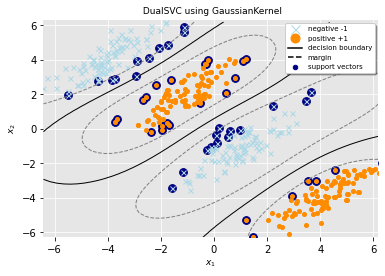

In [34]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [35]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                
cvxopt rbf    1    0.085442      -        0.998747           1.0          48   
              10   0.068151      -        0.998747           1.0          16   
              100  0.072836      -        0.997494           1.0          13   
smo    rbf    1    0.287050     42        0.998747           1.0          45   
              10   0.263121     58        0.998747           1.0          15   
              100  0.212068     87        0.998747           1.0          11   

                   val_n_sv  
solver kernel C              
cvxopt rbf    1          48  
              10         16  
              100        13  
smo    rbf    1          45  
              10         15  
              100        11

In [36]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                
cvxopt poly   1    0.083115      -        0.841242      0.671062          31   
              10   0.070198      -        0.961172      0.870609           9   
              100  0.070366      -        0.986248      0.972562           8   
       rbf    1    0.085442      -        0.998747      1.000000          48   
              10   0.068151      -        0.998747      1.000000          16   
              100  0.072836      -        0.997494      1.000000          13   
smo    poly   1    0.384261    140        0.847489      0.673568          29   
              10   0.493594    266        0.958675      0.868103           9   
              100  0.417218    221        0.987497      0.975068           7   
       rbf    1    0.287050     42        0.998747      1.000000          45   
              10   0.263121     58        0.998747      1.000000          15   
              100  0.212068     87        0.998747      1.000000          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          31  
              10          9  
              100         8  
       rbf    1          48  
              10         16  
              100        13  
smo    poly   1          29  
              10          9  
              100         7  
       rbf    1          45  
              10         15  
              100        11

In [37]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]

In [38]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                 
libsvm poly   1    0.002998     139             1.0           1.0          28   
              10   0.003866     330             1.0           1.0          10   
              100  0.002908     118             1.0           1.0           8   
       rbf    1    0.002391      93             1.0           1.0          42   
              10   0.004044     242             1.0           1.0          14   
              100  0.003652     240             1.0           1.0          12   

                   val_n_sv  
solver kernel C              
libsvm poly   1          28  
              10         10  
              100         8  
       rbf    1          42  
              10         14  
              100        12

In [39]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='h!')
nonlinear_dual_svc_cv_results

fit_time n_iter  train_accuracy  val_accuracy  train_n_sv  \
solver kernel C                                                                
cvxopt poly   1    0.083115      -        0.841242      0.671062          31   
              10   0.070198      -        0.961172      0.870609           9   
              100  0.070366      -        0.986248      0.972562           8   
       rbf    1    0.085442      -        0.998747      1.000000          48   
              10   0.068151      -        0.998747      1.000000          16   
              100  0.072836      -        0.997494      1.000000          13   
libsvm poly   1    0.002998    139        1.000000      1.000000          28   
              10   0.003866    330        1.000000      1.000000          10   
              100  0.002908    118        1.000000      1.000000           8   
       rbf    1    0.002391     93        1.000000      1.000000          42   
              10   0.004044    242        1.000000      1.000000          14   
              100  0.003652    240        1.000000      1.000000          12   
smo    poly   1    0.384261    140        0.847489      0.673568          29   
              10   0.493594    266        0.958675      0.868103           9   
              100  0.417218    221        0.987497      0.975068           7   
       rbf    1    0.287050     42        0.998747      1.000000          45   
              10   0.263121     58        0.998747      1.000000          15   
              100  0.212068     87        0.998747      1.000000          11   

                   val_n_sv  
solver kernel C              
cvxopt poly   1          31  
              10          9  
              100         8  
       rbf    1          48  
              10         16  
              100        13  
libsvm poly   1          28  
              10         10  
              100         8  
       rbf    1          42  
              10         14  
              100        12  
smo    poly   1          29  
              10          9  
              100         7  
       rbf    1          45  
              10         15  
              100        11

#### Lagrangian Dual

##### Linear

In [43]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [44]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='h!')
linear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  val_n_sv
dual C                                                                        
bcqp 1    0.004938       1            0.97      0.960048         127       127
     10   0.006212       1            0.97      0.960048         127       127
     100  0.005080       1            0.97      0.960048         127       127
qp   1    0.005731       1            0.97      0.965023         129       129
     10   0.004610       1            0.97      0.965023         129       129
     100  0.006694       1            0.97      0.965023         129       129

##### Nonlinear

In [45]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [46]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='h!')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  train_n_sv  \
dual kernel C                                                                 
bcqp poly   1    0.264804      55        0.828767      0.665769         199   
            10   0.229039      55        0.828767      0.665769         199   
            100  0.211480      55        0.828767      0.665769         199   
     rbf    1    0.019969       1        0.996245      0.985056         238   
            10   0.019845       1        0.996245      0.985056         238   
            100  0.019459       1        0.996245      0.985056         238   
qp   poly   1    0.610787     117        0.808698      0.601092         184   
            10   0.534400     117        0.808698      0.601092         184   
            100  0.466227     117        0.808698      0.601092         184   
     rbf    1    1.245540     260        0.777590      0.615513         151   
            10   0.194864      34        0.859870      0.606516         178   
            100  0.206384      48        0.887448      0.740863         190   

                 val_n_sv  
dual kernel C              
bcqp poly   1         199  
            10        199  
            100       199  
     rbf    1         238  
            10        238  
            100       238  
qp   poly   1         184  
            10        184  
            100       184  
     rbf    1         151  
            10        178  
            100       190

## Squared Hinge loss

### Primal formulation

In [47]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [48]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.iter + 1, 
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 9 candidates, totalling 27 fits


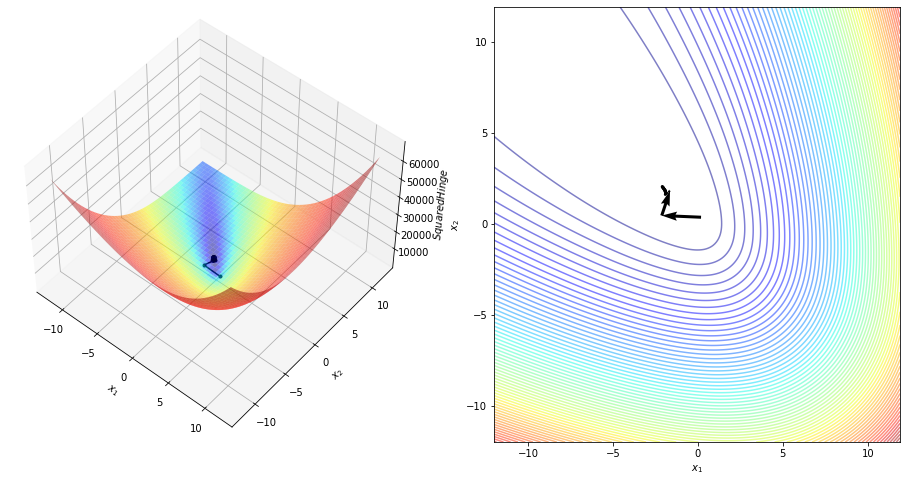

In [54]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, 
                              learning_rate=0.01, momentum=0.5, early_stopping=True, patience=5),
                    param_grid={'C': [1, 10, 100],
                                'momentum_type': ['none', 'standard', 'nesterov']},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [55]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'gd')
custom_primal_svc_squared_hinge_cv_results.sort_values(['C', 'momentum'], inplace=True)
custom_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
custom_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver C   momentum                                                   
gd     1   nesterov  0.078875     138        0.975012      0.959747   
           none      0.106522     178        0.969981      0.954772   
           standard  0.069786     113        0.972506      0.959747   
       10  nesterov  0.075062     136        0.972525      0.954847   
           none      0.085772     182        0.977518      0.949796   
           standard  0.062383     118        0.975012      0.949796   
       100 nesterov  0.015281      27        0.975012      0.959822   
           none      0.025448      44        0.979987      0.964873   
           standard  0.013901      23        0.972525      0.954772   

                     train_n_sv  val_n_sv  
solver C   momentum                        
gd     1   nesterov          28        13  
           none              30        15  
           standard          28        14  
       10  nesterov          15         8  
           none              18        11  
           standard          16         9  
       100 nesterov           7         3  
           none              11         5  
           standard           6         4

In [56]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [57]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'C', 'momentum'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
liblinear 1   -         0.001669     473        0.977500      0.975049   
          10  -         0.001815    1000        0.975012      0.975049   
          100 -         0.001460    1000        0.975012      0.970074   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
liblinear 1   -                 17         9  
          10  -                 13         6  
          100 -                 12         5

In [58]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='h!')
primal_svc_squared_hinge_cv_results

fit_time  n_iter  train_accuracy  val_accuracy  \
solver    C   momentum                                                   
gd        1   nesterov  0.078875     138        0.975012      0.959747   
              none      0.106522     178        0.969981      0.954772   
              standard  0.069786     113        0.972506      0.959747   
          10  nesterov  0.075062     136        0.972525      0.954847   
              none      0.085772     182        0.977518      0.949796   
              standard  0.062383     118        0.975012      0.949796   
          100 nesterov  0.015281      27        0.975012      0.959822   
              none      0.025448      44        0.979987      0.964873   
              standard  0.013901      23        0.972525      0.954772   
liblinear 1   -         0.001669     473        0.977500      0.975049   
          10  -         0.001815    1000        0.975012      0.975049   
          100 -         0.001460    1000        0.975012      0.970074   

                        train_n_sv  val_n_sv  
solver    C   momentum                        
gd        1   nesterov          28        13  
              none              30        15  
              standard          28        14  
          10  nesterov          15         8  
              none              18        11  
              standard          16         9  
          100 nesterov           7         3  
              none              11         5  
              standard           6         4  
liblinear 1   -                 17         9  
          10  -                 13         6  
          100 -                 12         5